In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
import warnings
import ipywidgets 
from tqdm.notebook import tqdm

In [2]:
# Replicates of eating

rep_eat = 1000

In [3]:
sm1 = pickle.load(open('../../Cell Invasion/new stan model.pkl', 'rb'))

fit_27 = pickle.load(open('../../Cell Invasion/fit_27.pkl', 'rb'))
fit_42 = pickle.load(open('../../Cell Invasion/fit_42.pkl', 'rb'))
fit_48 = pickle.load(open('../../Cell Invasion/fit_48.pkl', 'rb'))

samples_27 = fit_27.extract(permuted=True)
samples_42 = fit_42.extract(permuted=True)
samples_48 = fit_48.extract(permuted=True)

In [4]:
sm_Colonic_filling = pickle.load(open('stan_model_Colonic_filling.pkl', 'rb'))
fit_nuts_Colonic_filling = pickle.load(open('fit_nuts_Colonic_filling.pkl', 'rb'))
samples_Colonic_filling = fit_nuts_Colonic_filling.extract(permuted=True)

In [5]:
sm_retention = pickle.load(open('stan_model_Retention_time.pkl', 'rb'))
fit_nuts_Solid_retention = pickle.load(open('fit_nuts_Solid_Retention_time.pkl', 'rb'))
fit_nuts_Liquid_retention = pickle.load(open('fit_nuts_Liquid_Retention_time.pkl', 'rb'))
samples_Liquid_retention = fit_nuts_Liquid_retention.extract(permuted=True)
samples_Solid_retention = fit_nuts_Solid_retention.extract(permuted=True)

In [6]:
# Import pH change with individual person variability from .pickle
sm_pH_change = pickle.load(open('Stan model for pH change.pkl', 'rb'))
fit_nuts_pH_change_younger = pickle.load(open('fit_nuts_pH_change_younger.pkl', 'rb'))
fit_nuts_pH_change_elder = pickle.load(open('fit_nuts_pH_change_elder.pkl', 'rb'))
samples_pH_change_younger = fit_nuts_pH_change_younger.extract(permuted=True)
samples_pH_change_elder = fit_nuts_pH_change_elder.extract(permuted=True)

In [7]:
# Loading Baysian model of gastric reduction
sm_GR_between_strain = pickle.load(open('between-strain model.pkl', 'rb'))
fit_nuts_between_strain = pickle.load(open('fit_nuts_between_strain.pkl', 'rb'))
samples_between_strain = fit_nuts_between_strain.extract(permuted=True)


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

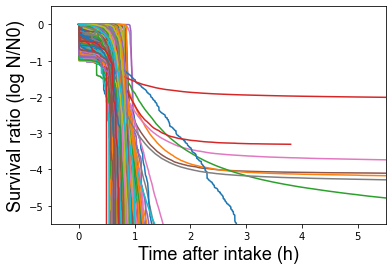

In [8]:
# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)

#Max Time (h) 
Tmax = 15

##### Definition of Gastric passage log counts
logSg_list = []
logSg0_list = []
logSg0 = np.zeros((Tmax, 1), dtype=float)
logSg = np.zeros((Tmax, 1), dtype=float)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
rcn_stomach_reduction_list = np.zeros((rep_eat, 1), dtype=int)
rcn_colonic_filling_list = np.zeros((rep_eat, 1), dtype=int)
rcn_invasion_list = np.zeros((rep_eat, 1), dtype=int)
t_star = []
##### Simulation of Gastric passage log counts

# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)



#Difinition of time-array (h) 
x =  np.zeros((Tmax*60*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60*60+1)

##### Definition of Gastric passage log counts
logSg0_list = []
logSg0 = np.zeros((len(x), 1), dtype=float)
t_star = []

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
pH_Lowest_list = np.zeros((rep_eat, 1), dtype=float)
pH_A_list = np.zeros((rep_eat, 1), dtype=float)
pH_k_list = np.zeros((rep_eat, 1), dtype=float)
pH_sigma_list = np.zeros((rep_eat, 1), dtype=float)
reduction_a_list = np.zeros((rep_eat, 1), dtype=float)
reduction_b_list = np.zeros((rep_eat, 1), dtype=float)
reduction_e_list = np.zeros((rep_eat, 1), dtype=float)
reduction_f_list = np.zeros((rep_eat, 1), dtype=float)


##### Simulation of Gastric passage log counts
warnings.simplefilter('ignore', RuntimeWarning)
for i in tqdm(range(rep_eat), desc = 'Progress', leave = False):
    
    rcn_pH = random.choice(range(len(samples_pH_change_younger["lp__"])))
    rcn_pH_list[i, 0] = rcn_pH
    
    Lowest = samples_pH_change_younger["Lowest"][rcn_pH]
    A = samples_pH_change_younger["A"][rcn_pH]
    k = samples_pH_change_younger["k"][rcn_pH]
    sigma_pH = samples_pH_change_younger["sigma"][rcn_pH]
    
    pH_Lowest_list[i, 0] = samples_pH_change_younger["Lowest"][rcn_pH]
    pH_A_list[i, 0] = samples_pH_change_younger["A"][rcn_pH]
    pH_k_list[i, 0] = samples_pH_change_younger["k"][rcn_pH]
    pH_sigma_list[i, 0] = samples_pH_change_younger["sigma"][rcn_pH]
    
    

    rcn_between_strain = random.choice(range(len(samples_between_strain["lp__"])))
    rcn_stomach_reduction_list[i, 0] = rcn_between_strain
    abef0 = samples_between_strain["abef0"][rcn_between_strain]
    cov = samples_between_strain["cov"][rcn_between_strain]
    abef = np.random.multivariate_normal(abef0, cov, size = 1)[0]
    
    a = abef[0]
    b = abef[1]
    e = abef[2]
    f = abef[3]
    
    reduction_a_list[i,0] = a
    reduction_b_list[i,0] = b
    reduction_e_list[i,0] = e
    reduction_f_list[i,0] = f
    
    Ni =  np.zeros((len(x), 1), dtype=float)
    Total =  np.zeros((len(x), 1), dtype=float)
    
    # Predict log reduction from between strain model
    for t in range(len(x)):
        if t==0:
            logSg0[t] = 0
            pH_before = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
        else :
            pH_next = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
            pH = (pH_before + pH_next)/2
            pH_before = pH_next
            logd = (a*pH+b)
            logp = e*pH+f
            logdp = [logd, logp]
            d = np.exp(logdp[0])/60
            p = np.exp(logdp[1])
            t_star =  d*(-(logSg0[t-1]))**(1/p)
            logSg0[t] = -((t_star+(x[t]-x[t-1]))/d)**p
    #plt.plot(np.arange(0, Tmax, 1, dtype="float")/3600, logSg, color="blue")
    plt.plot(x, logSg0, color=Palette[i])
    
    if i == 0:
        logSg0_list = logSg0
    else:
        logSg0_list = np.concatenate([logSg0_list, logSg0], axis = -1) 
        
plt.rcParams["font.family"] = "Arial"

plt.ylabel("Survival ratio (log N/N0)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()


In [9]:
x =  np.zeros((Tmax*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60+1)
logSg0_min = np.zeros((len(x), len(logSg0_list[0,:])), dtype=float)

for i in range(len(x)):
    logSg0_min[i,:] = logSg0_list[i*60,:]

logSg0_list=logSg0_min
logSg0_min=0

In [10]:
logSg0_quantile = np.zeros((len(logSg0_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(logSg0_list[:,0])),desc='Progress', leave=False):
    logSg0_quantile[n,:] =  np.quantile(logSg0_list[n,:],[ 0.05, 0.5, 0.95])
    

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

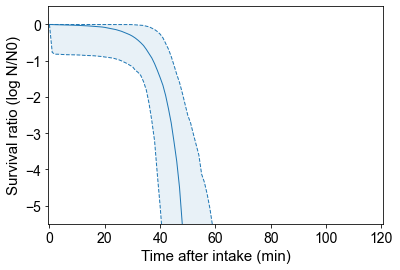

In [11]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0]*60, logSg0_quantile[:,0], logSg0_quantile[:,2], facecolor=Palette[0], alpha=0.1)
plt.plot(x[:,0]*60, logSg0_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0]*60, logSg0_quantile[:,0], lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0]*60, logSg0_quantile[:,1], lw=1, color=Palette[0], label="Survival ratio")

plt.ylabel("Survival ratio (log N/N0)", size=15, fontname="Arial")
plt.xlabel("Time after intake (min)",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-0.5, 120.5)
plt.ylim(-5.5, 0.5)
plt.show()

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

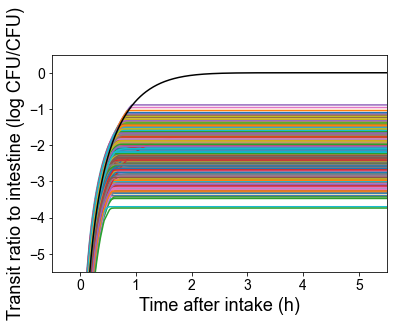

In [12]:
from scipy.stats import gamma
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_alpha_list = np.zeros((rep_eat, 1), dtype=float)
rcn_gastric_retention_beta_list = np.zeros((rep_eat, 1), dtype=float)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Solid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Solid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Solid_retention["beta"][rcn_gastric_retention]
    rcn_gastric_retention_alpha_list[q, 0] = alpha
    rcn_gastric_retention_beta_list[q, 0] = beta
    
    
    
    for i in range(len(x)):
        Sg = 10**logSg_using[i]
        
        dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Ni_t = Ni_t + dNi
        Ni[i, 0] = Ni_t
        
        dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Total_t = Total_t + dTotal
        Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [13]:
samples_Solid_retention["beta"][rcn_gastric_retention]

0.09888573255039078

In [14]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

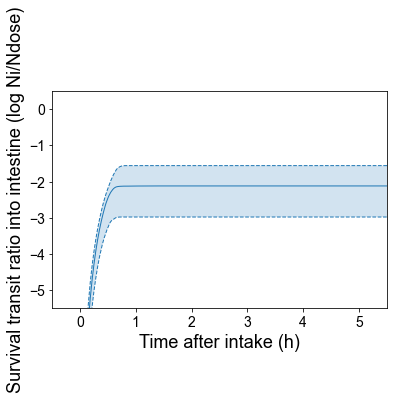

In [15]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


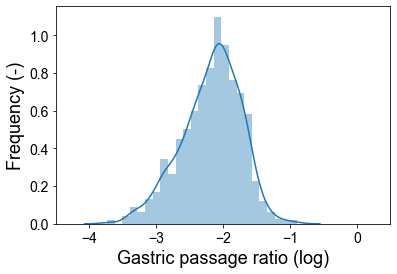

In [16]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [17]:
def rk4 ( y, t, h, f ):
    k1 = h * f( y, t )
    k2 = h * f( y + k1/2, t + h/2 )
    k3 = h * f( y + k2/2, t + h/2 )
    k4 = h * f( y + k3, t + h )
    return  y + ( k1 + 2*k2 + 2*k3 + k4 )/6, t + h

In [18]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.zeros((1, rep_eat), dtype=float)

S = 32*10**4

P_invasion_27_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_42_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_48_mcmc = np.zeros((1, rep_eat), dtype=float)

colonic_filling_list = np.zeros((1, rep_eat), dtype=float)

Nc_27 = np.zeros((rep_eat, 1), dtype=float)
Nc_42 = np.zeros((rep_eat, 1), dtype=float)
Nc_48 = np.zeros((rep_eat, 1), dtype=float)

In [19]:
Nc_min_27_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_42_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_48_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
warnings.simplefilter('ignore', RuntimeWarning)
for n in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    
    rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
    rcn_colonic_filling_list[n] = rcn
    rcn = random.randrange(len(samples_27["LogNmax"]))
    rcn_invasion_list[n] = rcn
    
    logdose[0,n] = np.random.uniform(low=-2,high=6,size=1)[0]
    
    t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn_colonic_filling_list[n, 0]],
                                        1/samples_Colonic_filling["beta"][rcn_colonic_filling_list[n, 0]])))
    t = np.min((t,len(Ni_min[:, 0])-1))
    colonic_filling_list[0, n] = t
        
    LogNmax_27 = samples_27["LogNmax"][rcn_invasion_list[n]]
    Logmu_27 = samples_27["Logmu"][rcn_invasion_list[n]]
    sigma_27 = samples_27["sigma"][rcn_invasion_list[n]]
    Nmax_27 = 10**LogNmax_27
    mu_27 = 10**Logmu_27

    LogNmax_42 = samples_42["LogNmax"][rcn_invasion_list[n]]
    Logmu_42 = samples_42["Logmu"][rcn_invasion_list[n]]
    sigma_42 = samples_42["sigma"][rcn_invasion_list[n]]
    Nmax_42 = 10**LogNmax_42
    mu_42 = 10**Logmu_42

    LogNmax_48 = samples_48["LogNmax"][rcn_invasion_list[n]]
    Logmu_48 = samples_48["Logmu"][rcn_invasion_list[n]]
    sigma_48 = samples_48["sigma"][rcn_invasion_list[n]]
    Nmax_48 = 10**LogNmax_48
    mu_48 = 10**Logmu_48

    for i in range(len(Ni_min[:, 0])):
        
        Ni = Ni_min[i, n]*10**logdose[0,n]
            
        T = i/60
        h = 1/60
    
        def ODE_27 (y, t):
            return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

        def ODE_42 (y, t):
            return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

        def ODE_48 (y, t):
            return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
        if i==0:
            Nc_min_27[i, n] = 0
            Nc_min_42[i, n] = 0
            Nc_min_48[i, n] = 0
                
        else:
                
            Nc_min_mean_27[i, n] = rk4 ( Nc_min_mean_27[i-1, n], T-h, h, ODE_27)[0]
            Nc_min_27[i, n] = Nc_min_mean_27[i, n]
        
            Nc_min_mean_42[i, n] = rk4 ( Nc_min_mean_42[i-1, n], T-h, h, ODE_42)[0]
            Nc_min_42[i, n] = Nc_min_mean_42[i, n]
        
            Nc_min_mean_48[i, n] = rk4 ( Nc_min_mean_48[i-1, n], T-h, h, ODE_48)[0]
            Nc_min_48[i, n] = Nc_min_mean_48[i, n]

        
    
        
        
    Nc_min_27_list[1,n]= Nc_min_27[t,n]
    Nc_27[n, 0]  = Nc_min_27[t,n]
    ratio_27 = Nc_min_27[t,n]/10**logdose[0,n]    
    P_invasion_27 =  1- (1-ratio_27)**(10**logdose[0,n])
    P_invasion_27_mcmc[0,n] = P_invasion_27
        
    Nc_min_42_list[1,n]= Nc_min_42[t,n]
    Nc_42[n, 0]  = Nc_min_42[t,n]
    ratio_42 = Nc_min_42[t,n]/10**logdose[0,n]    
    P_invasion_42 =  1- (1-ratio_42)**(10**logdose[0,n])
    P_invasion_42_mcmc[0,n] = P_invasion_42
        
    Nc_min_48_list[1,n]= Nc_min_48[t,n]
    Nc_48[n, 0]  = Nc_min_48[t,n]
    ratio_48 = Nc_min_48[t,n]/10**logdose[0,n]    
    P_invasion_48 =  1- (1-ratio_48)**(10**logdose[0,n])
    P_invasion_48_mcmc[0,n] = P_invasion_48
    
    

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
print(Nc_min_mean_27[i, n],
      Nc_min_mean_27[i, n],
      Nc_min_mean_27[i, n])

1929.0910023980755 1929.0910023980755 1929.0910023980755


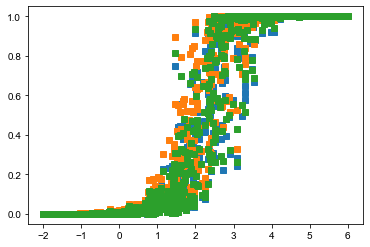

In [21]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.plot(logdose[0,:],P_invasion_42_mcmc[0,:],lw=0, marker="s",color=Palette[1])
plt.plot(logdose[0,:],P_invasion_48_mcmc[0,:],lw=0, marker="s",color=Palette[2])
plt.show()

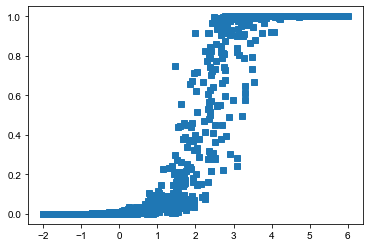

In [22]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.show()

In [23]:

pH_mean = np.zeros((rep_eat, 1), dtype=float)
pH_mean_50 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_25 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_10 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_1 = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_a = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_b = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_e = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_f = np.zeros((rep_eat, 1), dtype=float)
logSg0_mean = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_48 = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_alpha = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_beta = np.zeros((rep_eat, 1), dtype=float)
colonic_filling = np.zeros((rep_eat, 1), dtype=float)
Prob_27 = np.zeros((rep_eat, 1), dtype=float)
Prob_42 = np.zeros((rep_eat, 1), dtype=float)
Prob_48 = np.zeros((rep_eat, 1), dtype=float)


for i in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    stomach_reduction_a[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][0]
    stomach_reduction_b[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][1]
    stomach_reduction_e[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][2]
    stomach_reduction_f[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][3]
    logSg0_mean[i, 0] = np.mean(logSg0_list[:, i])
    invasion_LogNmax_27[i, 0] = samples_27["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_27[i, 0] = samples_27["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_27[i, 0] = samples_27["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_42[i, 0] = samples_42["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_42[i, 0] = samples_42["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_42[i, 0] = samples_42["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_48[i, 0] = samples_48["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_48[i, 0] = samples_48["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_48[i, 0] = samples_48["sigma"][int(rcn_invasion_list[i, 0])]
    
    colonic_filling_alpha[i, 0] = samples_Colonic_filling["alpha"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling_beta[i, 0] = samples_Colonic_filling["beta"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling[i, 0] = colonic_filling_list[0,i]/60
    Prob_27[i, 0] = P_invasion_27_mcmc[0,i]
    Prob_42[i, 0] = P_invasion_42_mcmc[0,i]
    Prob_48[i, 0] = P_invasion_48_mcmc[0,i]
    

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
Sensitivity_df_27_young_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_27[:, 0],
                                              'invasion_Logmu': invasion_Logmu_27[:, 0],
                                              'Nc': np.log10(Nc_27)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 1.)[:, 0],
                                              'Invasion Probability' : Prob_27[:,0]})

In [25]:
Sensitivity_df_42_young_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_42[:, 0],
                                              'invasion_Logmu': invasion_Logmu_42[:, 0],
                                              'Nc': np.log10(Nc_42)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 3.)[:, 0],
                                              'Invasion Probability' : Prob_42[:,0]})

In [26]:
Sensitivity_df_48_young_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_48[:, 0],
                                              'invasion_Logmu': invasion_Logmu_48[:, 0],
                                              'Nc': np.log10(Nc_48)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 2.)[:, 0],
                                              'Invasion Probability' : Prob_48[:,0]})

In [27]:
Sensitivity_df_young_solid = pd.concat([Sensitivity_df_27_young_solid,Sensitivity_df_42_young_solid,Sensitivity_df_48_young_solid])

In [28]:
Sensitivity_df_young_solid

,LogDose,pH min.,pH0,pH k,pH sigma,stomach_reduction_a,stomach_reduction_b,stomach_reduction_e,stomach_reduction_f,Intestinal Survival Ratio,...,invasion_LogNmax,invasion_Logmu,Nc,colonic_filling_alpha,colonic_filling_beta,Intestinal Retention Time,Age,Food Type,Strain,Invasion Probability
0,0.907634,1.634590,3.239301,0.000235,0.538439,5.000562,-13.903011,-0.032171,0.469725,-2.435578,...,4.818986,-8.820463,-1.881935,8.164292,0.023643,6.300000,25.0,1.0,1.0,0.013049
1,4.095260,1.638679,3.292212,0.000241,0.539629,4.816852,-14.037172,-0.203288,0.485694,-2.428420,...,4.832190,-8.769404,1.314198,8.421950,0.024599,5.516667,25.0,1.0,1.0,1.000000
2,2.647668,1.601964,3.275244,0.000228,0.540542,3.910239,-10.526210,-0.931428,3.170229,-2.403061,...,4.919369,-8.719605,-0.094856,8.906137,0.025645,4.316667,25.0,1.0,1.0,0.552698
3,1.334007,1.601978,3.287730,0.000230,0.535887,5.151180,-14.881704,-0.576891,1.685548,-2.358462,...,4.914109,-8.821638,-1.401280,8.228190,0.024090,4.850000,25.0,1.0,1.0,0.038951
4,1.780307,1.578926,3.285906,0.000224,0.542814,4.322481,-12.430759,-0.826917,1.902371,-2.739066,...,4.822205,-8.770137,-1.176233,9.364519,0.027182,8.733333,25.0,1.0,1.0,0.064507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.889255,1.632357,3.246830,0.000238,0.539722,4.128683,-11.130614,-1.591050,5.160793,-2.887673,...,3.949246,-7.754098,-0.156489,9.423764,0.026849,8.000000,25.0,1.0,2.0,0.502302
996,5.087657,1.599853,3.281490,0.000230,0.535143,4.523239,-12.161838,-0.187060,0.986413,-1.824753,...,4.016916,-7.894872,2.904872,10.545277,0.030654,4.866667,25.0,1.0,2.0,1.000000
997,-0.268310,1.595550,3.328727,0.000235,0.533633,4.801490,-12.786667,0.452587,-1.014639,-1.719588,...,3.890131,-7.654915,-2.253458,9.629028,0.027772,5.100000,25.0,1.0,2.0,0.005592
998,-1.686651,1.544734,3.306598,0.000216,0.537393,5.319182,-14.912037,0.356884,-1.034113,-1.884853,...,4.029877,-7.878965,-3.854950,7.301125,0.021654,5.700000,25.0,1.0,2.0,0.000140


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

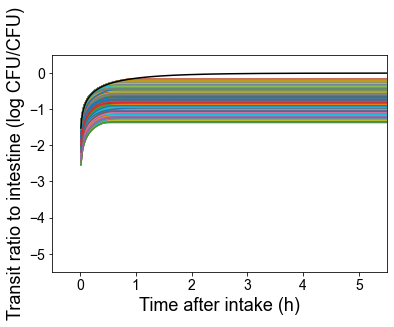

In [29]:
from scipy.stats import gamma
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_alpha_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_beta_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Liquid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Liquid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Liquid_retention["beta"][rcn_gastric_retention]
    rcn_gastric_retention_alpha_list[q, 0] = alpha
    rcn_gastric_retention_beta_list[q, 0] = beta
    
    
    
    for i in range(len(x)):
        if i == 0:
            Ni[i, 0] = 0
        else:
            Sg = 10**logSg_using[i]
        
            dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Ni_t = Ni_t + dNi
            Ni[i, 0] = Ni_t
        
            dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Total_t = Total_t + dTotal
            Total[i, 0] = Total_t

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [30]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

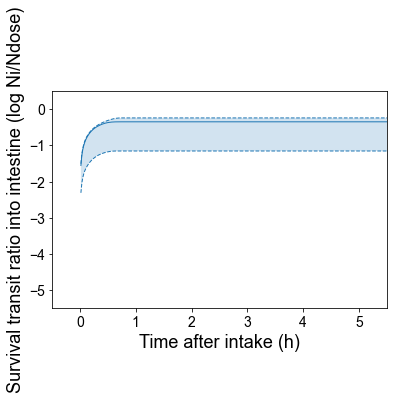

In [31]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


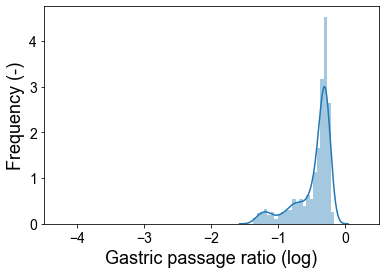

In [32]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [33]:
def rk4 ( y, t, h, f ):
    k1 = h * f( y, t )
    k2 = h * f( y + k1/2, t + h/2 )
    k3 = h * f( y + k2/2, t + h/2 )
    k4 = h * f( y + k3, t + h )
    return  y + ( k1 + 2*k2 + 2*k3 + k4 )/6, t + h

In [34]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.zeros((1, rep_eat), dtype=float)

S = 32*10**4

P_invasion_27_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_42_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_48_mcmc = np.zeros((1, rep_eat), dtype=float)

colonic_filling_list = np.zeros((1, rep_eat), dtype=float)

Nc_27 = np.zeros((rep_eat, 1), dtype=float)
Nc_42 = np.zeros((rep_eat, 1), dtype=float)
Nc_48 = np.zeros((rep_eat, 1), dtype=float)

In [35]:
Nc_min_27_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_42_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_48_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
warnings.simplefilter('ignore', RuntimeWarning)
for n in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    
    rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
    rcn_colonic_filling_list[n] = rcn
    rcn = random.randrange(len(samples_27["LogNmax"]))
    rcn_invasion_list[n] = rcn
    
    logdose[0,n] = np.random.uniform(low=-2,high=6,size=1)[0]
    
    t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn_colonic_filling_list[n, 0]],
                                        1/samples_Colonic_filling["beta"][rcn_colonic_filling_list[n, 0]])))
    t = np.min((t,len(Ni_min[:, 0])-1))
    colonic_filling_list[0, n] = t
        
    LogNmax_27 = samples_27["LogNmax"][rcn_invasion_list[n]]
    Logmu_27 = samples_27["Logmu"][rcn_invasion_list[n]]
    sigma_27 = samples_27["sigma"][rcn_invasion_list[n]]
    Nmax_27 = 10**LogNmax_27
    mu_27 = 10**Logmu_27

    LogNmax_42 = samples_42["LogNmax"][rcn_invasion_list[n]]
    Logmu_42 = samples_42["Logmu"][rcn_invasion_list[n]]
    sigma_42 = samples_42["sigma"][rcn_invasion_list[n]]
    Nmax_42 = 10**LogNmax_42
    mu_42 = 10**Logmu_42

    LogNmax_48 = samples_48["LogNmax"][rcn_invasion_list[n]]
    Logmu_48 = samples_48["Logmu"][rcn_invasion_list[n]]
    sigma_48 = samples_48["sigma"][rcn_invasion_list[n]]
    Nmax_48 = 10**LogNmax_48
    mu_48 = 10**Logmu_48

    for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, n]*10**logdose[0,n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, n] = 0
                Nc_min_42[i, n] = 0
                Nc_min_48[i, n] = 0
                
            else:
                
                Nc_min_mean_27[i, n] = rk4 ( Nc_min_mean_27[i-1, n], T-h, h, ODE_27)[0]
                Nc_min_27[i, n] = Nc_min_mean_27[i, n]
        
                Nc_min_mean_42[i, n] = rk4 ( Nc_min_mean_42[i-1, n], T-h, h, ODE_42)[0]
                Nc_min_42[i, n] = Nc_min_mean_42[i, n]
        
                Nc_min_mean_48[i, n] = rk4 ( Nc_min_mean_48[i-1, n], T-h, h, ODE_48)[0]
                Nc_min_48[i, n] = Nc_min_mean_48[i, n]

        
        
        
        
    Nc_min_27_list[1,n]= Nc_min_27[t,n]
    Nc_27[n, 0]  = Nc_min_27[t,n]
    ratio_27 = Nc_min_27[t,n]/10**logdose[0,n]    
    P_invasion_27 =  1- (1-ratio_27)**(10**logdose[0,n])
    P_invasion_27_mcmc[0,n] = P_invasion_27
        
    Nc_min_42_list[1,n]= Nc_min_42[t,n]
    Nc_42[n, 0]  = Nc_min_42[t,n]
    ratio_42 = Nc_min_42[t,n]/10**logdose[0,n]    
    P_invasion_42 =  1- (1-ratio_42)**(10**logdose[0,n])
    P_invasion_42_mcmc[0,n] = P_invasion_42
        
    Nc_min_48_list[1,n]= Nc_min_48[t,n]
    Nc_48[n, 0]  = Nc_min_48[t,n]
    ratio_48 = Nc_min_48[t,n]/10**logdose[0,n]    
    P_invasion_48 =  1- (1-ratio_48)**(10**logdose[0,n])
    P_invasion_48_mcmc[0,n] = P_invasion_48

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
len(Nc_27[:, 0])

1000

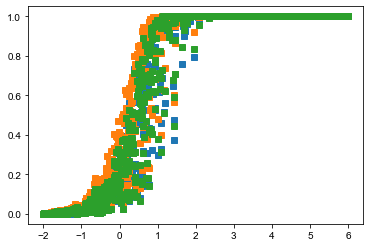

In [37]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.plot(logdose[0,:],P_invasion_42_mcmc[0,:],lw=0, marker="s",color=Palette[1])
plt.plot(logdose[0,:],P_invasion_48_mcmc[0,:],lw=0, marker="s",color=Palette[2])
plt.show()

In [38]:

pH_mean = np.zeros((rep_eat, 1), dtype=float)
pH_mean_50 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_25 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_10 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_1 = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_a = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_b = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_e = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_f = np.zeros((rep_eat, 1), dtype=float)
logSg0_mean = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_48 = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_alpha = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_beta = np.zeros((rep_eat, 1), dtype=float)
colonic_filling = np.zeros((rep_eat, 1), dtype=float)
Prob_27 = np.zeros((rep_eat, 1), dtype=float)
Prob_42 = np.zeros((rep_eat, 1), dtype=float)
Prob_48 = np.zeros((rep_eat, 1), dtype=float)


for i in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    stomach_reduction_a[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][0]
    stomach_reduction_b[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][1]
    stomach_reduction_e[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][2]
    stomach_reduction_f[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][3]
    logSg0_mean[i, 0] = np.mean(logSg0_list[:, i])
    invasion_LogNmax_27[i, 0] = samples_27["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_27[i, 0] = samples_27["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_27[i, 0] = samples_27["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_42[i, 0] = samples_42["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_42[i, 0] = samples_42["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_42[i, 0] = samples_42["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_48[i, 0] = samples_48["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_48[i, 0] = samples_48["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_48[i, 0] = samples_48["sigma"][int(rcn_invasion_list[i, 0])]
    
    colonic_filling_alpha[i, 0] = samples_Colonic_filling["alpha"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling_beta[i, 0] = samples_Colonic_filling["beta"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling[i, 0] = colonic_filling_list[0,i]/60
    Prob_27[i, 0] = P_invasion_27_mcmc[0,i]
    Prob_42[i, 0] = P_invasion_42_mcmc[0,i]
    Prob_48[i, 0] = P_invasion_48_mcmc[0,i]
    

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [39]:
Sensitivity_df_27_young_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_27[:, 0],
                                              'invasion_Logmu': invasion_Logmu_27[:, 0],
                                              'Nc': np.log10(Nc_27)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 1.)[:, 0],
                                              'Invasion Probability' : Prob_27[:,0]})

In [40]:
Sensitivity_df_42_young_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_42[:, 0],
                                              'invasion_Logmu': invasion_Logmu_42[:, 0],
                                              'Nc': np.log10(Nc_42)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 3.)[:, 0],
                                              'Invasion Probability' : Prob_42[:,0]})

In [41]:
Sensitivity_df_48_young_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_48[:, 0],
                                              'invasion_Logmu': invasion_Logmu_48[:, 0],
                                              'Nc': np.log10(Nc_48)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 25.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 2.)[:, 0],
                                              'Invasion Probability' : Prob_48[:,0]})

In [42]:
Sensitivity_df_young_liquid = pd.concat([Sensitivity_df_27_young_liquid,Sensitivity_df_42_young_liquid,Sensitivity_df_48_young_liquid])

In [43]:
Sensitivity_df_young_liquid

,LogDose,pH min.,pH0,pH k,pH sigma,stomach_reduction_a,stomach_reduction_b,stomach_reduction_e,stomach_reduction_f,Intestinal Survival Ratio,...,invasion_LogNmax,invasion_Logmu,Nc,colonic_filling_alpha,colonic_filling_beta,Intestinal Retention Time,Age,Food Type,Strain,Invasion Probability
0,3.601935,1.634590,3.239301,0.000235,0.538439,5.000562,-13.903011,-0.032171,0.469725,-0.425424,...,4.760040,-8.727356,2.895756,11.360917,0.031676,7.033333,25.0,0.0,1.0,1.000000
1,3.902770,1.638679,3.292212,0.000241,0.539629,4.816852,-14.037172,-0.203288,0.485694,-0.420855,...,4.878422,-8.712789,3.121149,9.549673,0.028426,4.066667,25.0,0.0,1.0,1.000000
2,5.348969,1.601964,3.275244,0.000228,0.540542,3.910239,-10.526210,-0.931428,3.170229,-0.582185,...,4.634965,-8.421907,4.330127,7.490830,0.021587,2.966667,25.0,0.0,1.0,1.000000
3,2.401751,1.601978,3.287730,0.000230,0.535887,5.151180,-14.881704,-0.576891,1.685548,-0.453545,...,5.161101,-9.091299,1.420610,7.675884,0.021523,3.166667,25.0,0.0,1.0,1.000000
4,5.497878,1.578926,3.285906,0.000224,0.542814,4.322481,-12.430759,-0.826917,1.902371,-0.862113,...,4.926319,-8.694974,4.282479,8.657105,0.025293,3.616667,25.0,0.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.840752,1.632357,3.246830,0.000238,0.539722,4.128683,-11.130614,-1.591050,5.160793,-1.068415,...,4.128889,-7.913592,3.440903,9.505493,0.028505,4.000000,25.0,0.0,2.0,1.000000
996,4.739162,1.599853,3.281490,0.000230,0.535143,4.523239,-12.161838,-0.187060,0.986413,-0.286775,...,4.037219,-7.791185,4.347101,7.873879,0.022748,8.916667,25.0,0.0,2.0,1.000000
997,0.817880,1.595550,3.328727,0.000235,0.533633,4.801490,-12.786667,0.452587,-1.014639,-0.263932,...,3.921156,-7.780731,0.302017,12.278371,0.035085,6.166667,25.0,0.0,2.0,0.908471
998,2.069547,1.544734,3.306598,0.000216,0.537393,5.319182,-14.912037,0.356884,-1.034113,-0.293521,...,3.950790,-7.805230,1.561943,8.906137,0.025645,6.950000,25.0,0.0,2.0,1.000000


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

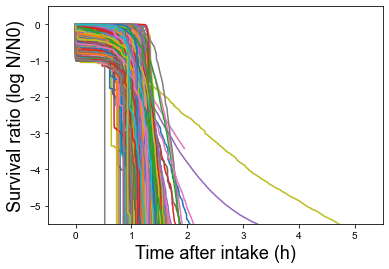

In [44]:
# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)

#Max Time (h) 
Tmax = 15

##### Definition of Gastric passage log counts
logSg_list = []
logSg0_list = []
logSg0 = np.zeros((Tmax, 1), dtype=float)
logSg = np.zeros((Tmax, 1), dtype=float)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
rcn_stomach_reduction_list = np.zeros((rep_eat, 1), dtype=int)
rcn_colonic_filling_list = np.zeros((rep_eat, 1), dtype=int)
rcn_invasion_list = np.zeros((rep_eat, 1), dtype=int)
t_star = []
##### Simulation of Gastric passage log counts

# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)



#Difinition of time-array (h) 
x =  np.zeros((Tmax*60*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60*60+1)

##### Definition of Gastric passage log counts
logSg0_list = []
logSg0 = np.zeros((len(x), 1), dtype=float)
t_star = []

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
pH_Lowest_list = np.zeros((rep_eat, 1), dtype=float)
pH_A_list = np.zeros((rep_eat, 1), dtype=float)
pH_k_list = np.zeros((rep_eat, 1), dtype=float)
pH_sigma_list = np.zeros((rep_eat, 1), dtype=float)
reduction_a_list = np.zeros((rep_eat, 1), dtype=float)
reduction_b_list = np.zeros((rep_eat, 1), dtype=float)
reduction_e_list = np.zeros((rep_eat, 1), dtype=float)
reduction_f_list = np.zeros((rep_eat, 1), dtype=float)


##### Simulation of Gastric passage log counts
warnings.simplefilter('ignore', RuntimeWarning)
for i in tqdm(range(rep_eat), desc = 'Progress', leave = False):
    
    rcn_pH = random.choice(range(len(samples_pH_change_elder["lp__"])))
    rcn_pH_list[i, 0] = rcn_pH
    
    Lowest = samples_pH_change_elder["Lowest"][rcn_pH]
    A = samples_pH_change_elder["A"][rcn_pH]
    k = samples_pH_change_elder["k"][rcn_pH]
    sigma_pH = samples_pH_change_elder["sigma"][rcn_pH]
    
    pH_Lowest_list[i, 0] = samples_pH_change_elder["Lowest"][rcn_pH]
    pH_A_list[i, 0] = samples_pH_change_elder["A"][rcn_pH]
    pH_k_list[i, 0] = samples_pH_change_elder["k"][rcn_pH]
    pH_sigma_list[i, 0] = samples_pH_change_elder["sigma"][rcn_pH]
    
    

    rcn_between_strain = random.choice(range(len(samples_between_strain["lp__"])))
    rcn_stomach_reduction_list[i, 0] = rcn_between_strain
    abef0 = samples_between_strain["abef0"][rcn_between_strain]
    cov = samples_between_strain["cov"][rcn_between_strain]
    abef = np.random.multivariate_normal(abef0, cov, size = 1)[0]
    
    a = abef[0]
    b = abef[1]
    e = abef[2]
    f = abef[3]
    
    reduction_a_list[i,0] = a
    reduction_b_list[i,0] = b
    reduction_e_list[i,0] = e
    reduction_f_list[i,0] = f
    
    Ni =  np.zeros((len(x), 1), dtype=float)
    Total =  np.zeros((len(x), 1), dtype=float)
    
    # Predict log reduction from between strain model
    for t in range(len(x)):
        if t==0:
            logSg0[t] = 0
            pH_before = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
        else :
            pH_next = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
            pH = (pH_before + pH_next)/2
            pH_before = pH_next
            logd = (a*pH+b)
            logp = e*pH+f
            logdp = [logd, logp]
            d = np.exp(logdp[0])/60
            p = np.exp(logdp[1])
            t_star =  d*(-(logSg0[t-1]))**(1/p)
            logSg0[t] = -((t_star+(x[t]-x[t-1]))/d)**p
    #plt.plot(np.arange(0, Tmax, 1, dtype="float")/3600, logSg, color="blue")
    plt.plot(x, logSg0, color=Palette[i])
    
    if i == 0:
        logSg0_list = logSg0
    else:
        logSg0_list = np.concatenate([logSg0_list, logSg0], axis = -1) 
        
plt.rcParams["font.family"] = "Arial"

plt.ylabel("Survival ratio (log N/N0)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()


In [45]:
x =  np.zeros((Tmax*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60+1)
logSg0_min = np.zeros((len(x), len(logSg0_list[0,:])), dtype=float)

for i in range(len(x)):
    logSg0_min[i,:] = logSg0_list[i*60,:]

logSg0_list=logSg0_min
logSg0_min=0

In [46]:
logSg0_quantile = np.zeros((len(logSg0_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(logSg0_list[:,0])),desc='Progress', leave=False):
    logSg0_quantile[n,:] =  np.quantile(logSg0_list[n,:],[ 0.05, 0.5, 0.95])
    

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

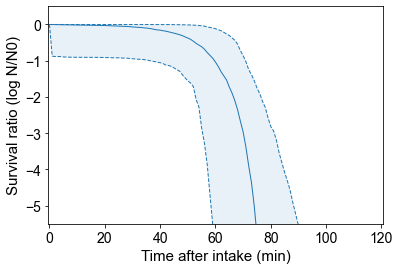

In [47]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0]*60, logSg0_quantile[:,0], logSg0_quantile[:,2], facecolor=Palette[0], alpha=0.1)
plt.plot(x[:,0]*60, logSg0_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0]*60, logSg0_quantile[:,0], lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0]*60, logSg0_quantile[:,1], lw=1, color=Palette[0], label="Survival ratio")

plt.ylabel("Survival ratio (log N/N0)", size=15, fontname="Arial")
plt.xlabel("Time after intake (min)",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-0.5, 120.5)
plt.ylim(-5.5, 0.5)
plt.show()

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

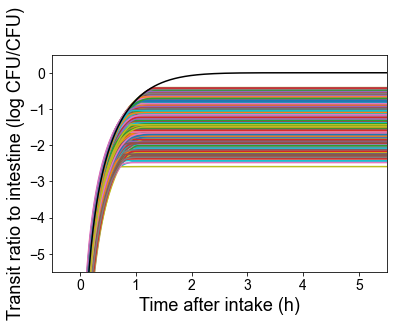

In [48]:
from scipy.stats import gamma
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_alpha_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_beta_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Solid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Solid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Solid_retention["beta"][rcn_gastric_retention]
    rcn_gastric_retention_alpha_list[q, 0] = alpha
    rcn_gastric_retention_beta_list[q, 0] = beta
    
    
    
    for i in range(len(x)):
        Sg = 10**logSg_using[i]
        
        dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Ni_t = Ni_t + dNi
        Ni[i, 0] = Ni_t
        
        dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Total_t = Total_t + dTotal
        Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [49]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

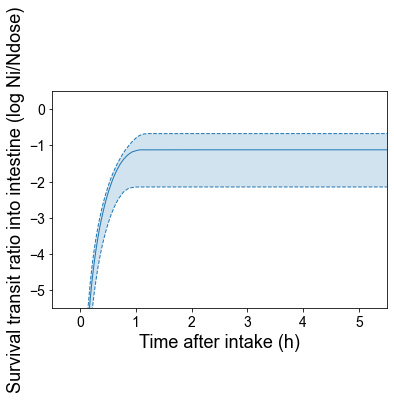

In [50]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


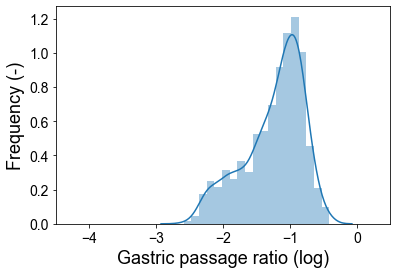

In [51]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [52]:
def rk4 ( y, t, h, f ):
    k1 = h * f( y, t )
    k2 = h * f( y + k1/2, t + h/2 )
    k3 = h * f( y + k2/2, t + h/2 )
    k4 = h * f( y + k3, t + h )
    return  y + ( k1 + 2*k2 + 2*k3 + k4 )/6, t + h

In [53]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.zeros((1, rep_eat), dtype=float)

S = 32*10**4

P_invasion_27_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_42_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_48_mcmc = np.zeros((1, rep_eat), dtype=float)

colonic_filling_list = np.zeros((1, rep_eat), dtype=float)

Nc_27 = np.zeros((rep_eat, 1), dtype=float)
Nc_42 = np.zeros((rep_eat, 1), dtype=float)
Nc_48 = np.zeros((rep_eat, 1), dtype=float)

In [54]:
Nc_min_27_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_42_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_48_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
warnings.simplefilter('ignore', RuntimeWarning)
for n in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    
    rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
    rcn_colonic_filling_list[n] = rcn
    rcn = random.randrange(len(samples_27["LogNmax"]))
    rcn_invasion_list[n] = rcn
    
    logdose[0,n] = np.random.uniform(low=-2,high=6,size=1)[0]
    
    t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn_colonic_filling_list[n, 0]],
                                        1/samples_Colonic_filling["beta"][rcn_colonic_filling_list[n, 0]])))
    t = np.min((t,len(Ni_min[:, 0])-1))
    colonic_filling_list[0, n] = t
        
    LogNmax_27 = samples_27["LogNmax"][rcn_invasion_list[n]]
    Logmu_27 = samples_27["Logmu"][rcn_invasion_list[n]]
    sigma_27 = samples_27["sigma"][rcn_invasion_list[n]]
    Nmax_27 = 10**LogNmax_27
    mu_27 = 10**Logmu_27

    LogNmax_42 = samples_42["LogNmax"][rcn_invasion_list[n]]
    Logmu_42 = samples_42["Logmu"][rcn_invasion_list[n]]
    sigma_42 = samples_42["sigma"][rcn_invasion_list[n]]
    Nmax_42 = 10**LogNmax_42
    mu_42 = 10**Logmu_42

    LogNmax_48 = samples_48["LogNmax"][rcn_invasion_list[n]]
    Logmu_48 = samples_48["Logmu"][rcn_invasion_list[n]]
    sigma_48 = samples_48["sigma"][rcn_invasion_list[n]]
    Nmax_48 = 10**LogNmax_48
    mu_48 = 10**Logmu_48

    for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, n]*10**logdose[0,n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, n] = 0
                Nc_min_42[i, n] = 0
                Nc_min_48[i, n] = 0
                
            else:
                
                Nc_min_mean_27[i, n] = rk4 ( Nc_min_mean_27[i-1, n], T-h, h, ODE_27)[0]
                Nc_min_27[i, n] = Nc_min_mean_27[i, n]
        
                Nc_min_mean_42[i, n] = rk4 ( Nc_min_mean_42[i-1, n], T-h, h, ODE_42)[0]
                Nc_min_42[i, n] = Nc_min_mean_42[i, n]
        
                Nc_min_mean_48[i, n] = rk4 ( Nc_min_mean_48[i-1, n], T-h, h, ODE_48)[0]
                Nc_min_48[i, n] = Nc_min_mean_48[i, n]

        
        
        
        
    Nc_min_27_list[1,n]= Nc_min_27[t,n]
    Nc_27[n, 0]  = Nc_min_27[t,n]
    ratio_27 = Nc_min_27[t,n]/10**logdose[0,n]    
    P_invasion_27 =  1- (1-ratio_27)**(10**logdose[0,n])
    P_invasion_27_mcmc[0,n] = P_invasion_27
        
    Nc_min_42_list[1,n]= Nc_min_42[t,n]
    Nc_42[n, 0]  = Nc_min_42[t,n]
    ratio_42 = Nc_min_42[t,n]/10**logdose[0,n]    
    P_invasion_42 =  1- (1-ratio_42)**(10**logdose[0,n])
    P_invasion_42_mcmc[0,n] = P_invasion_42
        
    Nc_min_48_list[1,n]= Nc_min_48[t,n]
    Nc_48[n, 0]  = Nc_min_48[t,n]
    ratio_48 = Nc_min_48[t,n]/10**logdose[0,n]    
    P_invasion_48 =  1- (1-ratio_48)**(10**logdose[0,n])
    P_invasion_48_mcmc[0,n] = P_invasion_48

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
len(Nc_27[:, 0])

1000

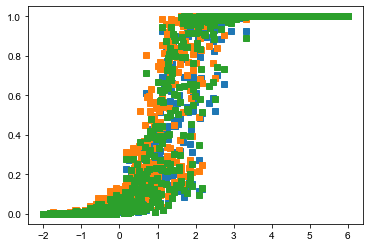

In [56]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.plot(logdose[0,:],P_invasion_42_mcmc[0,:],lw=0, marker="s",color=Palette[1])
plt.plot(logdose[0,:],P_invasion_48_mcmc[0,:],lw=0, marker="s",color=Palette[2])
plt.show()

In [57]:

pH_mean = np.zeros((rep_eat, 1), dtype=float)
pH_mean_50 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_25 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_10 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_1 = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_a = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_b = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_e = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_f = np.zeros((rep_eat, 1), dtype=float)
logSg0_mean = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_48 = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_alpha = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_beta = np.zeros((rep_eat, 1), dtype=float)
colonic_filling = np.zeros((rep_eat, 1), dtype=float)
Prob_27 = np.zeros((rep_eat, 1), dtype=float)
Prob_42 = np.zeros((rep_eat, 1), dtype=float)
Prob_48 = np.zeros((rep_eat, 1), dtype=float)


for i in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    stomach_reduction_a[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][0]
    stomach_reduction_b[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][1]
    stomach_reduction_e[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][2]
    stomach_reduction_f[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][3]
    logSg0_mean[i, 0] = np.mean(logSg0_list[:, i])
    invasion_LogNmax_27[i, 0] = samples_27["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_27[i, 0] = samples_27["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_27[i, 0] = samples_27["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_42[i, 0] = samples_42["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_42[i, 0] = samples_42["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_42[i, 0] = samples_42["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_48[i, 0] = samples_48["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_48[i, 0] = samples_48["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_48[i, 0] = samples_48["sigma"][int(rcn_invasion_list[i, 0])]
    
    colonic_filling_alpha[i, 0] = samples_Colonic_filling["alpha"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling_beta[i, 0] = samples_Colonic_filling["beta"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling[i, 0] = colonic_filling_list[0,i]/60
    Prob_27[i, 0] = P_invasion_27_mcmc[0,i]
    Prob_42[i, 0] = P_invasion_42_mcmc[0,i]
    Prob_48[i, 0] = P_invasion_48_mcmc[0,i]
    

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
Sensitivity_df_27_elder_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_27[:, 0],
                                              'invasion_Logmu': invasion_Logmu_27[:, 0],
                                              'Nc': np.log10(Nc_27)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 1.)[:, 0],
                                              'Invasion Probability' : Prob_27[:,0]})

In [59]:
Sensitivity_df_42_elder_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_42[:, 0],
                                              'invasion_Logmu': invasion_Logmu_42[:, 0],
                                              'Nc': np.log10(Nc_42)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 3.)[:, 0],
                                              'Invasion Probability' : Prob_42[:,0]})

In [60]:
Sensitivity_df_48_elder_solid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_48[:, 0],
                                              'invasion_Logmu': invasion_Logmu_48[:, 0],
                                              'Nc': np.log10(Nc_48)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 1.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 2.)[:, 0],
                                              'Invasion Probability' : Prob_48[:,0]})

In [61]:
Sensitivity_df_elder_solid = pd.concat([Sensitivity_df_27_elder_solid,Sensitivity_df_42_elder_solid,Sensitivity_df_48_elder_solid])

In [62]:
Sensitivity_df_elder_solid

,LogDose,pH min.,pH0,pH k,pH sigma,stomach_reduction_a,stomach_reduction_b,stomach_reduction_e,stomach_reduction_f,Intestinal Survival Ratio,...,invasion_LogNmax,invasion_Logmu,Nc,colonic_filling_alpha,colonic_filling_beta,Intestinal Retention Time,Age,Food Type,Strain,Invasion Probability
0,5.953875,1.207044,4.010590,0.000112,0.736687,4.941276,-13.145035,0.443983,-0.551429,-2.288770,...,5.028219,-8.897768,3.280105,7.973734,0.022996,4.533333,71.0,1.0,1.0,1.000000
1,1.373358,1.254977,4.029786,0.000115,0.736157,4.313030,-11.657664,-1.455238,5.160503,-2.297232,...,5.058564,-8.895243,-1.084018,6.490710,0.019392,8.666667,71.0,1.0,1.0,0.079239
2,0.840232,1.098595,4.132486,0.000106,0.732080,4.839483,-14.173886,-0.015476,-0.063459,-1.407546,...,5.060033,-8.954534,-0.774689,9.061730,0.026225,8.266667,71.0,1.0,1.0,0.156397
3,-1.506961,1.255375,4.043432,0.000115,0.736921,5.310633,-15.875660,-0.860536,1.935484,-1.875949,...,4.900122,-8.740391,-3.611022,9.019004,0.026762,6.900000,71.0,1.0,1.0,0.000246
4,-0.714546,1.209660,4.038738,0.000111,0.736415,5.383662,-14.690741,0.096135,0.373368,-0.811422,...,4.877148,-8.728839,-1.930950,8.490935,0.025324,4.350000,71.0,1.0,1.0,0.012022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.006619,1.198291,4.076965,0.000110,0.731729,4.004429,-10.535779,-3.039901,9.818734,-2.247973,...,4.099214,-7.923468,-1.383222,7.903788,0.022494,9.133333,71.0,1.0,2.0,0.040616
996,3.032685,1.211853,4.020264,0.000112,0.729184,4.039286,-11.192365,-0.806301,2.082301,-1.659575,...,3.945783,-7.912548,1.148297,8.547592,0.024718,9.133333,71.0,1.0,2.0,0.999999
997,1.829590,1.264449,3.992845,0.000113,0.738512,3.954235,-11.421168,-1.775424,5.257761,-2.334965,...,4.055713,-7.926625,-0.785569,8.149918,0.023366,6.166667,71.0,1.0,2.0,0.151295
998,0.570670,1.225738,4.053603,0.000113,0.739477,5.307011,-14.691986,-0.996219,3.922331,-1.434679,...,4.011532,-7.803954,-1.131730,7.103339,0.020906,5.516667,71.0,1.0,2.0,0.071865


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

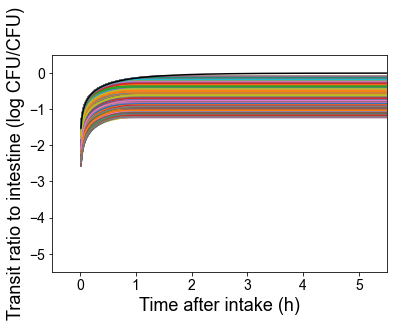

In [63]:
from scipy.stats import gamma
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_alpha_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_beta_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Liquid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Liquid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Liquid_retention["beta"][rcn_gastric_retention]
    rcn_gastric_retention_alpha_list[q, 0] = alpha
    rcn_gastric_retention_beta_list[q, 0] = beta
    
    
    
    for i in range(len(x)):
        if i == 0:
            Ni[i, 0] = 0
        else:
            Sg = 10**logSg_using[i]
        
            dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Ni_t = Ni_t + dNi
            Ni[i, 0] = Ni_t
        
            dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Total_t = Total_t + dTotal
            Total[i, 0] = Total_t

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [64]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

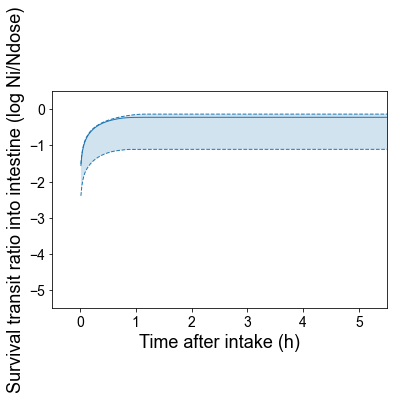

In [65]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


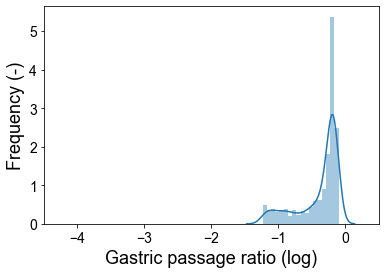

In [66]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [67]:
def rk4 ( y, t, h, f ):
    k1 = h * f( y, t )
    k2 = h * f( y + k1/2, t + h/2 )
    k3 = h * f( y + k2/2, t + h/2 )
    k4 = h * f( y + k3, t + h )
    return  y + ( k1 + 2*k2 + 2*k3 + k4 )/6, t + h

In [68]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.zeros((1, rep_eat), dtype=float)

S = 32*10**4

P_invasion_27_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_42_mcmc = np.zeros((1, rep_eat), dtype=float)

P_invasion_48_mcmc = np.zeros((1, rep_eat), dtype=float)

colonic_filling_list = np.zeros((1, rep_eat), dtype=float)

Nc_27 = np.zeros((rep_eat, 1), dtype=float)
Nc_42 = np.zeros((rep_eat, 1), dtype=float)
Nc_48 = np.zeros((rep_eat, 1), dtype=float)

In [69]:
Nc_min_27_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_42_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
Nc_min_48_list = np.zeros((len(Ni_min[:,0]), rep_eat), dtype=float)
warnings.simplefilter('ignore', RuntimeWarning)
for n in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    
    rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
    rcn_colonic_filling_list[n] = rcn
    rcn = random.randrange(len(samples_27["LogNmax"]))
    rcn_invasion_list[n] = rcn
    
    logdose[0,n] = np.random.uniform(low=-2,high=6,size=1)[0]
    
    t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn_colonic_filling_list[n, 0]],
                                        1/samples_Colonic_filling["beta"][rcn_colonic_filling_list[n, 0]])))
    t = np.min((t,len(Ni_min[:, 0])-1))
    colonic_filling_list[0, n] = t
        
    LogNmax_27 = samples_27["LogNmax"][rcn_invasion_list[n]]
    Logmu_27 = samples_27["Logmu"][rcn_invasion_list[n]]
    sigma_27 = samples_27["sigma"][rcn_invasion_list[n]]
    Nmax_27 = 10**LogNmax_27
    mu_27 = 10**Logmu_27

    LogNmax_42 = samples_42["LogNmax"][rcn_invasion_list[n]]
    Logmu_42 = samples_42["Logmu"][rcn_invasion_list[n]]
    sigma_42 = samples_42["sigma"][rcn_invasion_list[n]]
    Nmax_42 = 10**LogNmax_42
    mu_42 = 10**Logmu_42

    LogNmax_48 = samples_48["LogNmax"][rcn_invasion_list[n]]
    Logmu_48 = samples_48["Logmu"][rcn_invasion_list[n]]
    sigma_48 = samples_48["sigma"][rcn_invasion_list[n]]
    Nmax_48 = 10**LogNmax_48
    mu_48 = 10**Logmu_48

    for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, n]*10**logdose[0,n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, n] = 0
                Nc_min_42[i, n] = 0
                Nc_min_48[i, n] = 0
                
            else:
                
                Nc_min_mean_27[i, n] = rk4 ( Nc_min_mean_27[i-1, n], T-h, h, ODE_27)[0]
                Nc_min_27[i, n] = Nc_min_mean_27[i, n]
        
                Nc_min_mean_42[i, n] = rk4 ( Nc_min_mean_42[i-1, n], T-h, h, ODE_42)[0]
                Nc_min_42[i, n] = Nc_min_mean_42[i, n]
        
                Nc_min_mean_48[i, n] = rk4 ( Nc_min_mean_48[i-1, n], T-h, h, ODE_48)[0]
                Nc_min_48[i, n] = Nc_min_mean_48[i, n]

        
        
        
        
    Nc_min_27_list[1,n]= Nc_min_27[t,n]
    Nc_27[n, 0]  = Nc_min_27[t,n]
    ratio_27 = Nc_min_27[t,n]/10**logdose[0,n]    
    P_invasion_27 =  1- (1-ratio_27)**(10**logdose[0,n])
    P_invasion_27_mcmc[0,n] = P_invasion_27
        
    Nc_min_42_list[1,n]= Nc_min_42[t,n]
    Nc_42[n, 0]  = Nc_min_42[t,n]
    ratio_42 = Nc_min_42[t,n]/10**logdose[0,n]    
    P_invasion_42 =  1- (1-ratio_42)**(10**logdose[0,n])
    P_invasion_42_mcmc[0,n] = P_invasion_42
        
    Nc_min_48_list[1,n]= Nc_min_48[t,n]
    Nc_48[n, 0]  = Nc_min_42[t,n]
    ratio_48 = Nc_min_48[t,n]/10**logdose[0,n]    
    P_invasion_48 =  1- (1-ratio_48)**(10**logdose[0,n])
    P_invasion_48_mcmc[0,n] = P_invasion_48

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
len(Nc_27[:, 0])

1000

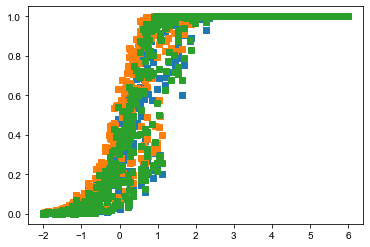

In [71]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.plot(logdose[0,:],P_invasion_42_mcmc[0,:],lw=0, marker="s",color=Palette[1])
plt.plot(logdose[0,:],P_invasion_48_mcmc[0,:],lw=0, marker="s",color=Palette[2])
plt.show()

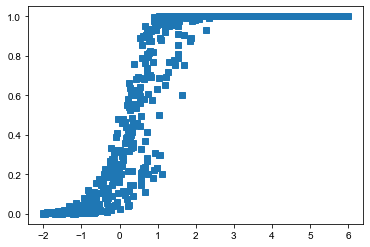

In [72]:
plt.plot(logdose[0,:],P_invasion_27_mcmc[0,:],lw=0, marker="s",color=Palette[0])
plt.show()

In [73]:

pH_mean = np.zeros((rep_eat, 1), dtype=float)
pH_mean_50 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_25 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_10 = np.zeros((rep_eat, 1), dtype=float)
pH_mean_1 = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_a = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_b = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_e = np.zeros((rep_eat, 1), dtype=float)
stomach_reduction_f = np.zeros((rep_eat, 1), dtype=float)
logSg0_mean = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_27 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_42 = np.zeros((rep_eat, 1), dtype=float)
invasion_LogNmax_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_Logmu_48 = np.zeros((rep_eat, 1), dtype=float)
invasion_sigma_48 = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_alpha = np.zeros((rep_eat, 1), dtype=float)
colonic_filling_beta = np.zeros((rep_eat, 1), dtype=float)
colonic_filling = np.zeros((rep_eat, 1), dtype=float)
Prob_27 = np.zeros((rep_eat, 1), dtype=float)
Prob_42 = np.zeros((rep_eat, 1), dtype=float)
Prob_48 = np.zeros((rep_eat, 1), dtype=float)


for i in tqdm(range(rep_eat) ,desc='Progress', leave=False):
    stomach_reduction_a[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][0]
    stomach_reduction_b[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][1]
    stomach_reduction_e[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][2]
    stomach_reduction_f[i, 0] = samples_between_strain["abef0"][int(rcn_stomach_reduction_list[i,0])][3]
    logSg0_mean[i, 0] = np.mean(logSg0_list[:, i])
    invasion_LogNmax_27[i, 0] = samples_27["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_27[i, 0] = samples_27["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_27[i, 0] = samples_27["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_42[i, 0] = samples_42["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_42[i, 0] = samples_42["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_42[i, 0] = samples_42["sigma"][int(rcn_invasion_list[i, 0])]
    invasion_LogNmax_48[i, 0] = samples_48["LogNmax"][int(rcn_invasion_list[i, 0])]
    invasion_Logmu_48[i, 0] = samples_48["Logmu"][int(rcn_invasion_list[i, 0])]
    invasion_sigma_48[i, 0] = samples_48["sigma"][int(rcn_invasion_list[i, 0])]
    
    colonic_filling_alpha[i, 0] = samples_Colonic_filling["alpha"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling_beta[i, 0] = samples_Colonic_filling["beta"][int(rcn_colonic_filling_list[i, 0])]
    colonic_filling[i, 0] = colonic_filling_list[0,i]/60
    Prob_27[i, 0] = P_invasion_27_mcmc[0,i]
    Prob_42[i, 0] = P_invasion_42_mcmc[0,i]
    Prob_48[i, 0] = P_invasion_48_mcmc[0,i]
    

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
Sensitivity_df_27_elder_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_27[:, 0],
                                              'invasion_Logmu': invasion_Logmu_27[:, 0],
                                              'Nc': np.log10(Nc_27)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 1.)[:, 0],
                                              'Invasion Probability' : Prob_27[:,0]})

In [75]:
Sensitivity_df_42_elder_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_42[:, 0],
                                              'invasion_Logmu': invasion_Logmu_42[:, 0],
                                              'Nc': np.log10(Nc_42)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 3.)[:, 0],
                                              'Invasion Probability' : Prob_42[:,0]})

In [76]:
Sensitivity_df_48_elder_liquid = pd.DataFrame({'LogDose' : logdose[0,:],
                                              'pH min.' : pH_Lowest_list[:,0],
                                              'pH0' : pH_A_list[:, 0],
                                              'pH k' : pH_k_list[:, 0],
                                              'pH sigma' : pH_sigma_list[:, 0],
                                              'stomach_reduction_a': reduction_a_list[:, 0],
                                              'stomach_reduction_b': reduction_b_list[:, 0],
                                              'stomach_reduction_e': reduction_e_list[:, 0],
                                              'stomach_reduction_f': reduction_f_list[:, 0],
                                              'Intestinal Survival Ratio': np.log10(Ni_list)[-1,:],
                                              'Gastric retention alpha': rcn_gastric_retention_alpha_list[:, 0],
                                              'Gastric retention beta': rcn_gastric_retention_beta_list[:, 0],
                                              'invasion_LogNmax': invasion_LogNmax_48[:, 0],
                                              'invasion_Logmu': invasion_Logmu_48[:, 0],
                                              'Nc': np.log10(Nc_48)[:, 0],
                                              'colonic_filling_alpha': colonic_filling_alpha[:, 0],
                                              'colonic_filling_beta': colonic_filling_beta[:, 0],
                                              'Intestinal Retention Time': colonic_filling[:, 0],
                                              'Age': np.full((rep_eat, 1), 71.)[:, 0],
                                              'Food Type': np.full((rep_eat, 1), 0.)[:, 0],
                                              'Strain':np.full((rep_eat, 1), 2.)[:, 0],
                                              'Invasion Probability' : Prob_48[:,0]})

In [77]:
Sensitivity_df_elder_liquid = pd.concat([Sensitivity_df_27_elder_liquid,Sensitivity_df_42_elder_liquid,Sensitivity_df_48_elder_liquid])

In [78]:
Sensitivity_df_elder_liquid

,LogDose,pH min.,pH0,pH k,pH sigma,stomach_reduction_a,stomach_reduction_b,stomach_reduction_e,stomach_reduction_f,Intestinal Survival Ratio,...,invasion_LogNmax,invasion_Logmu,Nc,colonic_filling_alpha,colonic_filling_beta,Intestinal Retention Time,Age,Food Type,Strain,Invasion Probability
0,3.728466,1.207044,4.010590,0.000112,0.736687,4.941276,-13.145035,0.443983,-0.551429,-1.017731,...,4.830080,-8.861836,2.357211,10.356473,0.030459,6.533333,71.0,0.0,1.0,1.000000
1,4.206730,1.254977,4.029786,0.000115,0.736157,4.313030,-11.657664,-1.455238,5.160503,-1.016856,...,5.014672,-8.870907,2.858517,9.738273,0.028532,4.750000,71.0,0.0,1.0,1.000000
2,3.266274,1.098595,4.132486,0.000106,0.732080,4.839483,-14.173886,-0.015476,-0.063459,-0.258525,...,5.272198,-9.051055,2.763267,9.162760,0.026718,5.316667,71.0,0.0,1.0,1.000000
3,-1.184725,1.255375,4.043432,0.000115,0.736921,5.310633,-15.875660,-0.860536,1.935484,-0.850583,...,5.010963,-9.025713,-2.413868,8.382964,0.024011,5.866667,71.0,0.0,1.0,0.003966
4,0.018615,1.209660,4.038738,0.000111,0.736415,5.383662,-14.690741,0.096135,0.373368,-0.149650,...,4.871322,-8.746296,-0.607702,7.608116,0.022055,3.400000,71.0,0.0,1.0,0.245386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.516137,1.198291,4.076965,0.000110,0.731729,4.004429,-10.535779,-3.039901,9.818734,-1.208424,...,4.006117,-7.863790,3.268839,9.522155,0.028276,6.650000,71.0,0.0,2.0,1.000000
996,2.105320,1.211853,4.020264,0.000112,0.729184,4.039286,-11.192365,-0.806301,2.082301,-0.766565,...,3.924278,-7.792156,1.277722,10.417224,0.030304,7.666667,71.0,0.0,2.0,1.000000
997,0.878935,1.264449,3.992845,0.000113,0.738512,3.954235,-11.421168,-1.775424,5.257761,-1.215790,...,4.065983,-7.866691,-0.432408,9.318434,0.026850,6.100000,71.0,0.0,2.0,0.246510
998,5.353795,1.225738,4.053603,0.000113,0.739477,5.307011,-14.691986,-0.996219,3.922331,-0.445813,...,3.793080,-7.647069,4.776075,8.889032,0.025821,5.450000,71.0,0.0,2.0,1.000000


In [79]:
Sensitivity_df = pd.concat([Sensitivity_df_young_solid, Sensitivity_df_young_liquid, Sensitivity_df_elder_solid, Sensitivity_df_elder_liquid])

In [80]:
Sensitivity_df = Sensitivity_df.rename(columns={'stomach_reduction_a': 'Stomach reduction a', 
                                                'stomach_reduction_b':'Stomach reduction b', 
                                                'stomach_reduction_e':'Stomach reduction e',
                                                'stomach_reduction_f':'Stomach reduction f', 
                                                'invasion_LogNmax':'Invasion LogNmax', 
                                                'invasion_Logmu':'Invasion ratio', 
                                                'invasion_sigma':'Invasion sigma', 
                                                'Nc':'N invading', 
                                                'colonic_filling_alpha':'Intestinal retention alpha', 
                                                'colonic_filling_beta':'Intestinal retention beta'})

In [81]:
Sensitivity_df=Sensitivity_df.dropna(how='any')

In [82]:
Sensitivity_df

,LogDose,pH min.,pH0,pH k,pH sigma,Stomach reduction a,Stomach reduction b,Stomach reduction e,Stomach reduction f,Intestinal Survival Ratio,...,Invasion LogNmax,Invasion ratio,N invading,Intestinal retention alpha,Intestinal retention beta,Intestinal Retention Time,Age,Food Type,Strain,Invasion Probability
0,0.907634,1.634590,3.239301,0.000235,0.538439,5.000562,-13.903011,-0.032171,0.469725,-2.435578,...,4.818986,-8.820463,-1.881935,8.164292,0.023643,6.300000,25.0,1.0,1.0,0.013049
1,4.095260,1.638679,3.292212,0.000241,0.539629,4.816852,-14.037172,-0.203288,0.485694,-2.428420,...,4.832190,-8.769404,1.314198,8.421950,0.024599,5.516667,25.0,1.0,1.0,1.000000
2,2.647668,1.601964,3.275244,0.000228,0.540542,3.910239,-10.526210,-0.931428,3.170229,-2.403061,...,4.919369,-8.719605,-0.094856,8.906137,0.025645,4.316667,25.0,1.0,1.0,0.552698
3,1.334007,1.601978,3.287730,0.000230,0.535887,5.151180,-14.881704,-0.576891,1.685548,-2.358462,...,4.914109,-8.821638,-1.401280,8.228190,0.024090,4.850000,25.0,1.0,1.0,0.038951
4,1.780307,1.578926,3.285906,0.000224,0.542814,4.322481,-12.430759,-0.826917,1.902371,-2.739066,...,4.822205,-8.770137,-1.176233,9.364519,0.027182,8.733333,25.0,1.0,1.0,0.064507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.516137,1.198291,4.076965,0.000110,0.731729,4.004429,-10.535779,-3.039901,9.818734,-1.208424,...,4.006117,-7.863790,3.268839,9.522155,0.028276,6.650000,71.0,0.0,2.0,1.000000
996,2.105320,1.211853,4.020264,0.000112,0.729184,4.039286,-11.192365,-0.806301,2.082301,-0.766565,...,3.924278,-7.792156,1.277722,10.417224,0.030304,7.666667,71.0,0.0,2.0,1.000000
997,0.878935,1.264449,3.992845,0.000113,0.738512,3.954235,-11.421168,-1.775424,5.257761,-1.215790,...,4.065983,-7.866691,-0.432408,9.318434,0.026850,6.100000,71.0,0.0,2.0,0.246510
998,5.353795,1.225738,4.053603,0.000113,0.739477,5.307011,-14.691986,-0.996219,3.922331,-0.445813,...,3.793080,-7.647069,4.776075,8.889032,0.025821,5.450000,71.0,0.0,2.0,1.000000


In [83]:
Sensitivity_df.corr(method="spearman")["Invasion Probability"]

LogDose                       0.914721
pH min.                      -0.073738
pH0                           0.068681
pH k                         -0.070871
pH sigma                      0.064536
Stomach reduction a           0.017855
Stomach reduction b           0.001874
Stomach reduction e           0.095138
Stomach reduction f          -0.081165
Intestinal Survival Ratio     0.279179
Gastric retention alpha      -0.234716
Gastric retention beta       -0.216881
Invasion LogNmax              0.001680
Invasion ratio                0.007323
N invading                    0.968389
Intestinal retention alpha    0.010939
Intestinal retention beta     0.008437
Intestinal Retention Time     0.021401
Age                           0.082892
Food Type                    -0.245860
Strain                        0.031607
Invasion Probability          1.000000
Name: Invasion Probability, dtype: float64

In [84]:
Sensitivity_corr = Sensitivity_df.corr(method="spearman")

In [85]:
Sensitivity_corr = Sensitivity_corr.reindex(Sensitivity_corr["Invasion Probability"].abs().sort_values().index)

In [86]:
Sensitivity_corr["Invasion Probability"]

Invasion LogNmax              0.001680
Stomach reduction b           0.001874
Invasion ratio                0.007323
Intestinal retention beta     0.008437
Intestinal retention alpha    0.010939
Stomach reduction a           0.017855
Intestinal Retention Time     0.021401
Strain                        0.031607
pH sigma                      0.064536
pH0                           0.068681
pH k                         -0.070871
pH min.                      -0.073738
Stomach reduction f          -0.081165
Age                           0.082892
Stomach reduction e           0.095138
Gastric retention beta       -0.216881
Gastric retention alpha      -0.234716
Food Type                    -0.245860
Intestinal Survival Ratio     0.279179
LogDose                       0.914721
N invading                    0.968389
Invasion Probability          1.000000
Name: Invasion Probability, dtype: float64

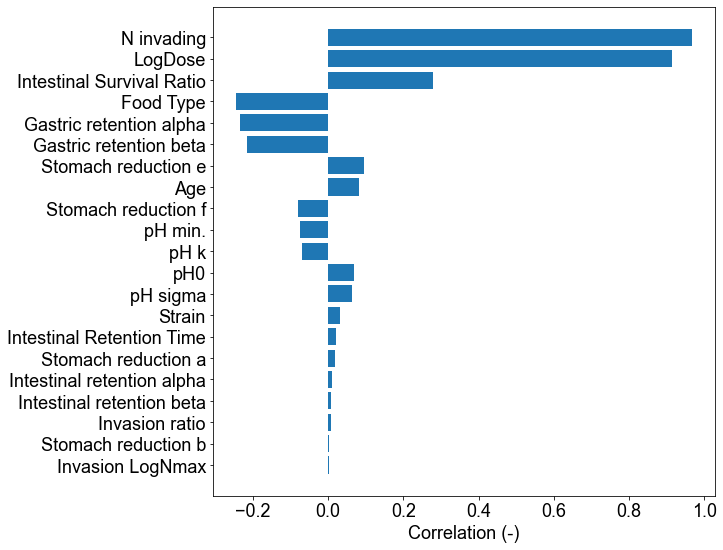

In [87]:
fig = plt.figure(figsize =(9,9))
ax = fig.add_subplot(111)
ax.barh(Sensitivity_corr.index[0:len(Sensitivity_corr["Invasion Probability"])-1], Sensitivity_corr["Invasion Probability"][0:len(Sensitivity_corr["Invasion Probability"])-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Correlation (-)", size=18, fontname="Arial")
plt.show()

ValueError: cannot reindex from a duplicate axis

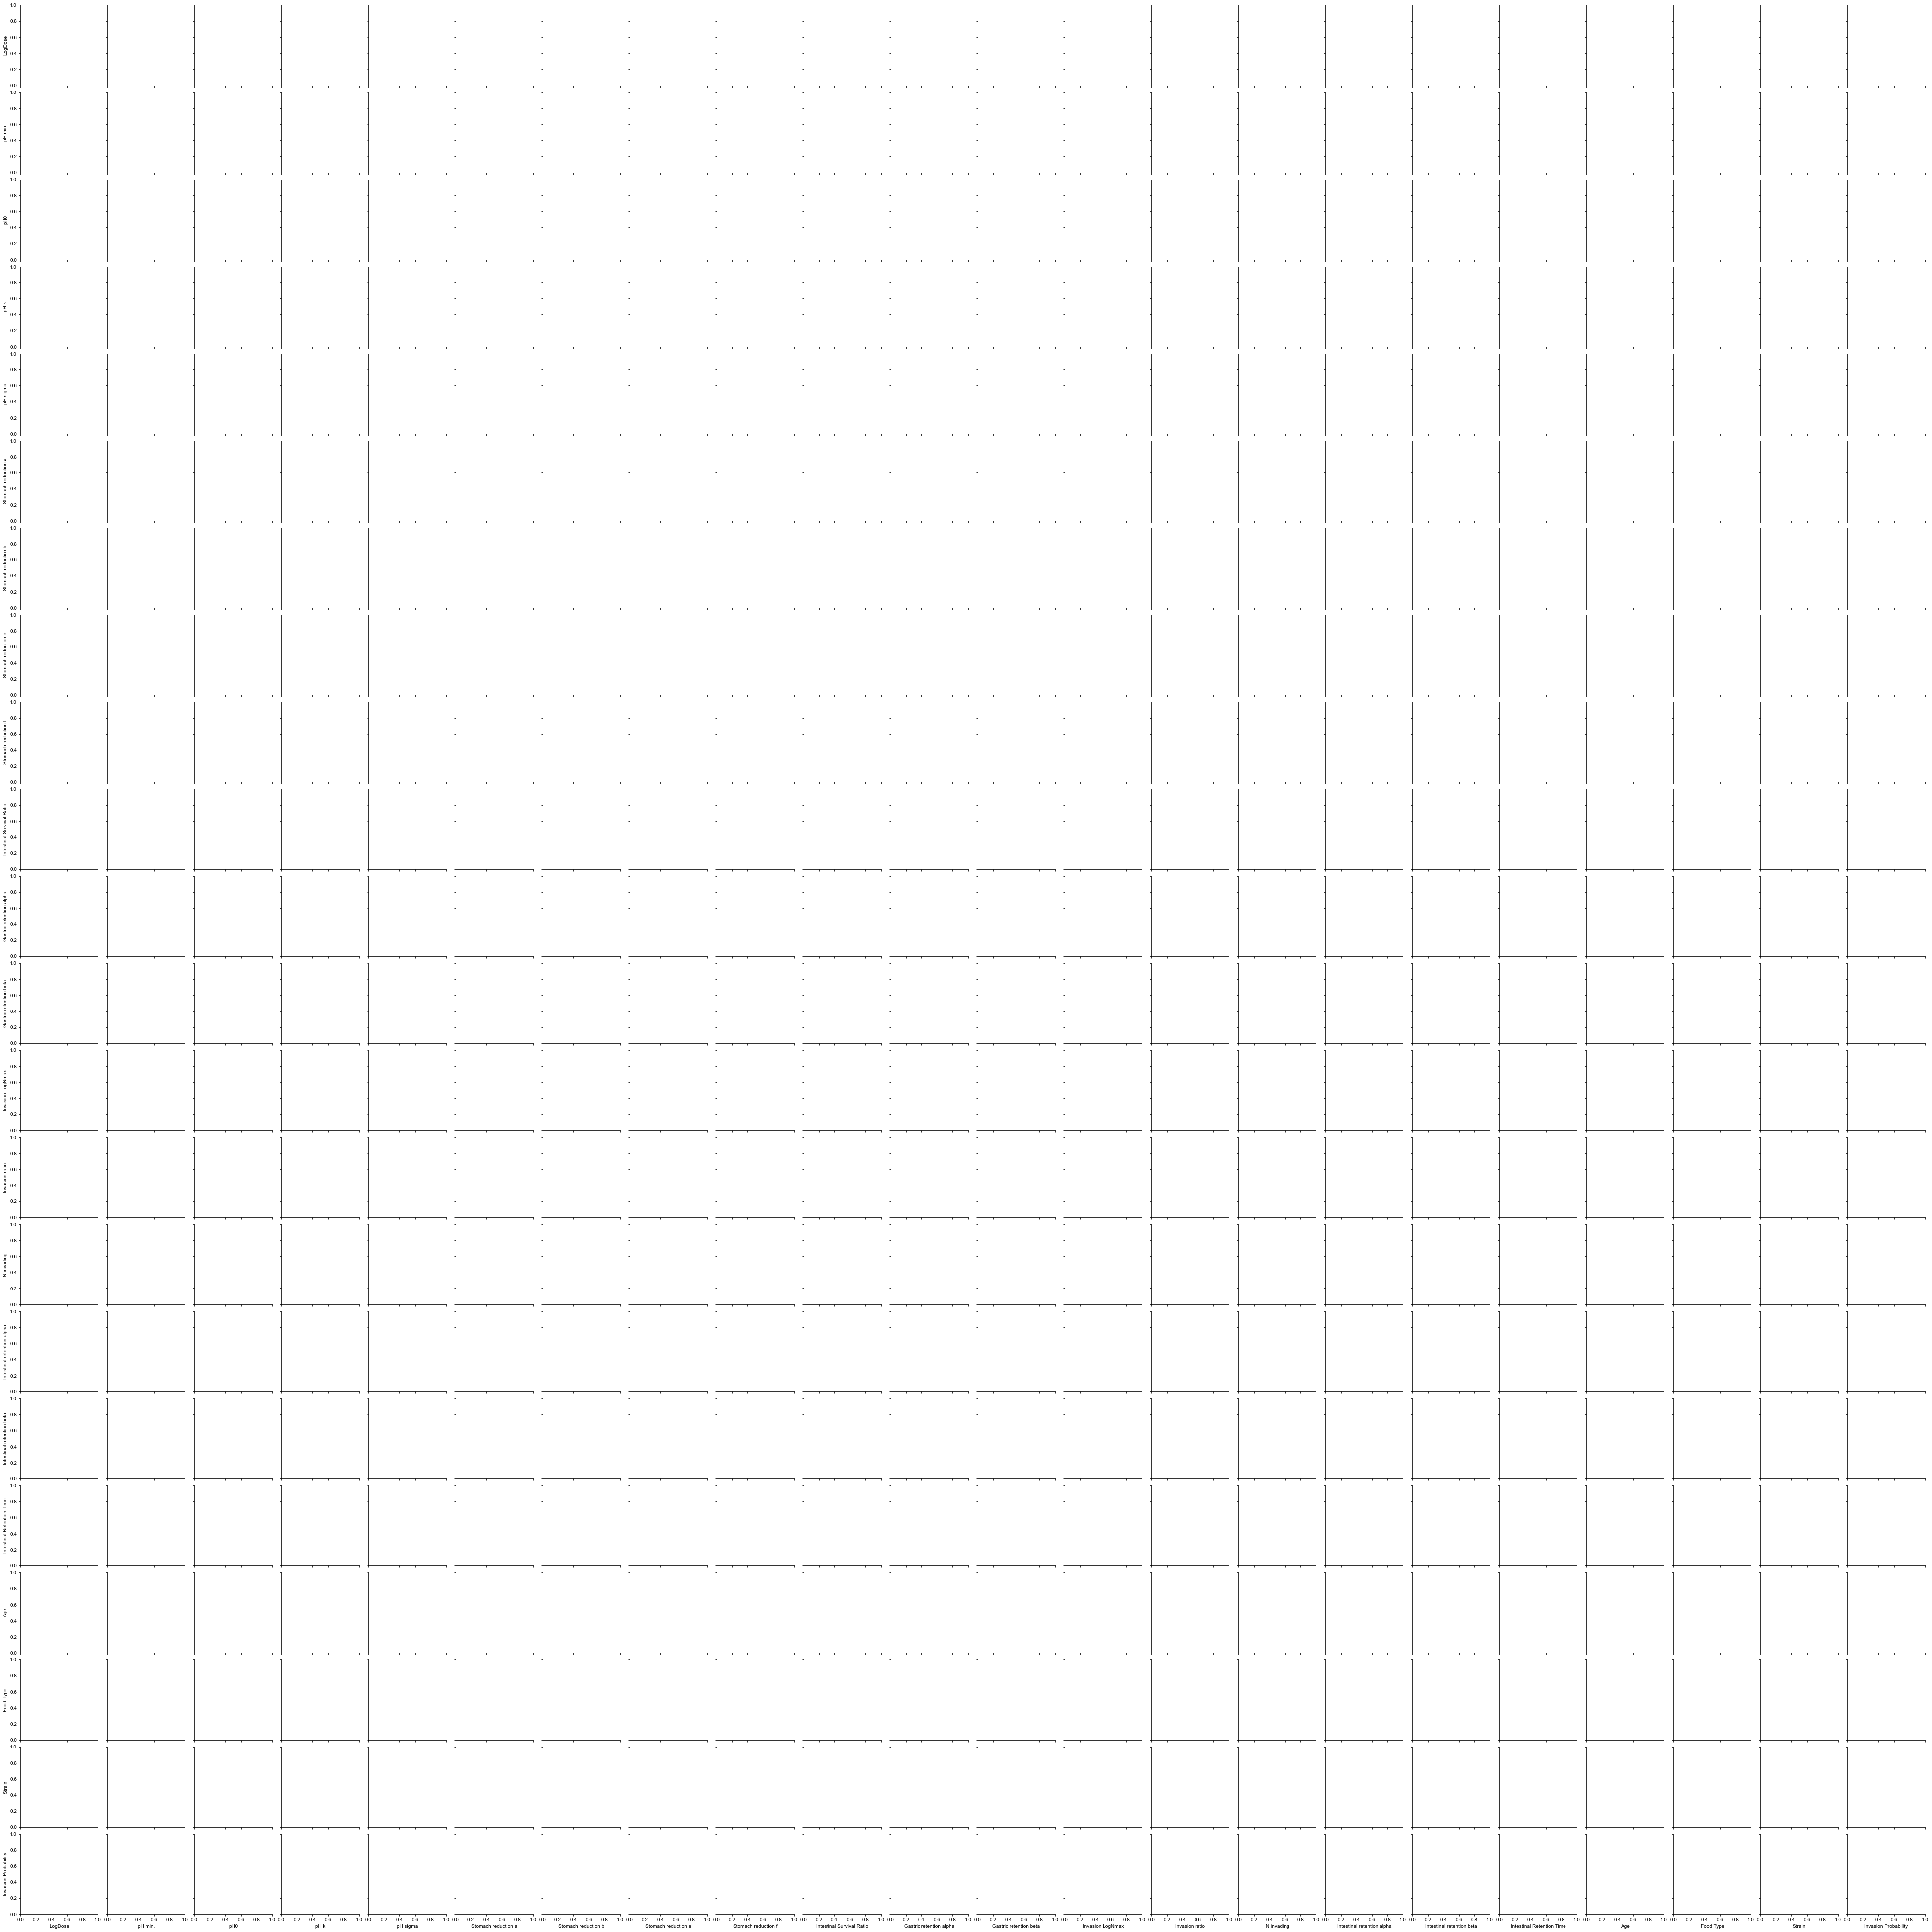

In [88]:
sns.pairplot(Sensitivity_df)

In [ ]:
Sensitivity_df.dropna(how='any')

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["N invading"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["LogDose"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Intestinal Survival Ratio"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Gastric retention alpha"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Gastric retention beta"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Food Type"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Stomach reduction e"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Age"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["pH0"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Stomach reduction f"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["pH min."]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["pH k"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["pH sigma"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Stomach reduction a"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Intestinal retention alpha"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Intestinal retention beta"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Stomach reduction b"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Intestinal Retention Time"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Invasion ratio"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Invasion LogNmax"]
)

In [ ]:
from scipy.stats import spearmanr
spearmanr(
    Sensitivity_df["Invasion Probability"], 
    Sensitivity_df["Strain"]
)